# Sklearn optimize

In [6]:
from sklearn.base import clone
from skopt import gp_minimize
import skopt.plots
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence

import os, sys
from non_linear_error import calculate_rdt_ptc
from non_linear_error import calculate_rdt_madng
from non_linear_error import calculate_rdt_pymadng

import numpy as np

In [7]:
noise = 0.2
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
# Use custom kernel and estimator to match previous example

def f_ptc(ksd1_a23b1_corr):
    """
    Ground truth simulation function
    Input: Vector with the predicted magnet corrections
    Output: RMS beta beat or RMS RDT
    """
    with HiddenPrints():
        mean_f30000 = calculate_rdt_ptc(ksd1_a23b1_corr)
    print("[x,y]: ", ksd1_a23b1_corr, ",", -mean_f30000)
    return -mean_f30000 # Negative sign to minimize not maximize

In [8]:
#%%

def f_madng(corr):
    """
    Ground truth simulation function
    Input: Vector with the predicted magnet corrections
    Output: RMS beta beat or RMS RDT
    """
    with HiddenPrints():
        mean_f30000 = calculate_rdt_pymadng(corr)[0]
    print("[x,y]: ", corr, ",", -100*mean_f30000)
    return -100*mean_f30000 # Negative sign to minimize not maximize

# SINGLE ERROR

[x,y]:  [0.] , -3.6279612950418705


[x,y]:  [-0.01] , -2.570153340750436


[x,y]:  [0.01] , -5.395641355859474


[x,y]:  [0.01986316] , -7.565646756939618


[x,y]:  [0.00666127] , -4.741824061551019


[x,y]:  [-0.01448579] , -2.531985624084224


[x,y]:  [0.01489146] , -6.435629881492276


[x,y]:  [-0.00121049] , -3.4584218392694046


[x,y]:  [-0.01272986] , -2.468585994512748


[x,y]:  [0.00198789] , -3.929620939821796


[x,y]:  [-0.01703777] , -2.8519162021332303


[x,y]:  [0.00741696] , -4.885062080269742


[x,y]:  [-0.01576444] , -2.666565063979891


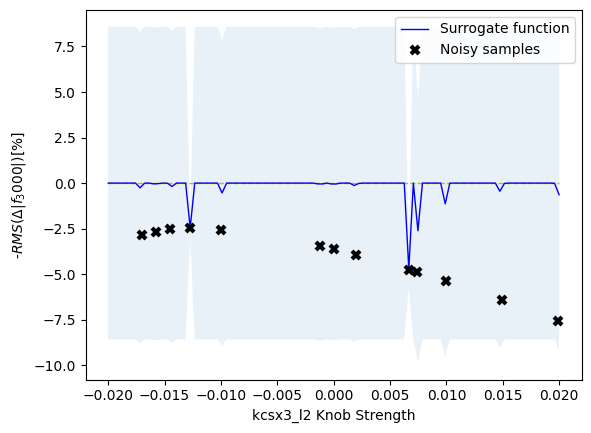

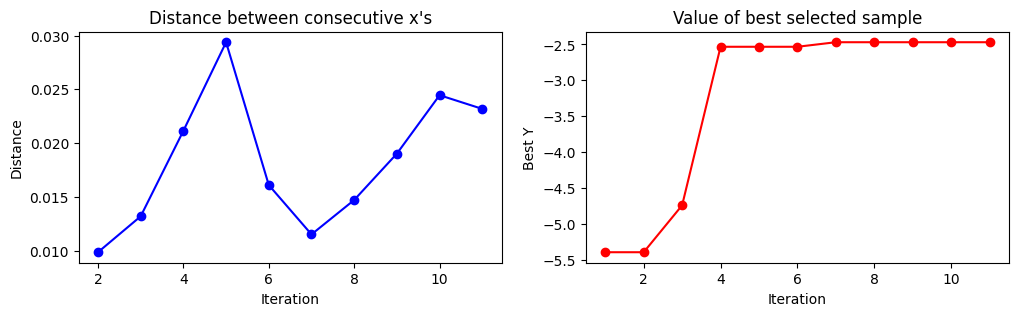

In [10]:
# Define bounds and initialization values

bounds = np.array([[-2.0E-2, 2.0E-2]])

# Use custom kernel and estimator to match previous example

X_init = np.array([[0], [-1E-2], [1E-2]])
Y_init = np.array([f_madng(x) for x in X_init])

# Dense grid of points within bounds
X = np.linspace(bounds[:, 0], bounds[:, 1], 100).reshape(-1, 1)

# Noise-free objective function values at X 
Y = [0 for x in X]#f(X,0)

m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52) #kernel=m52 noise**2

r = gp_minimize(lambda x: -f_madng(np.array(x)),
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)
# Noise-free objective function values at X 

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)
plot_convergence(np.array(r.x_iters), -r.func_vals)
    

# Multiple errors

In [9]:
bounds = np.array([[-2.0E-2, 2.0E-2],[-2.0E-2, 2.0E-2]])

X_init = np.array([[0, 0], [-1E-2, -1E-2], [1E-2, 1E-2]])
Y_init = np.array([f_madng(x) for x in X_init])


m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=0.04)#, alpha=noise**2)


r = gp_minimize(lambda x: -f_madng(np.array(x)),
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=30,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
#plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)
#plot_convergence(np.array(r.x_iters), -r.func_vals)

[x,y]:  [0. 0.] , -3.3971106069469363


[x,y]:  [-0.01 -0.01] , -1.0089638181212648


[x,y]:  [0.01 0.01] , -5.866905181791165


[x,y]:  [ 0.00181881 -0.01476663] , -3.8403511042993554


[x,y]:  [0.00177494 0.01215085] , -3.830276529020349


[x,y]:  [-0.00355735  0.01565537] , -2.5373894334726366


[x,y]:  [ 0.01884859 -0.01398153] , -8.112227588331717


[x,y]:  [0.00645711 0.01755179] , -4.983688946056278


[x,y]:  [0.00163746 0.00455585] , -3.7964810908883777


[x,y]:  [-2.00000000e-02  6.64205983e-07] , -1.427119466243276


[x,y]:  [-0.02 -0.02] , -1.4268628033123718


[x,y]:  [-0.02  0.02] , -1.4273797242502824


[x,y]:  [-0.01548759 -0.01015633] , -0.9279664063535857


[x,y]:  [-0.01551164 -0.01012564] , -0.9289556180446727


[x,y]:  [-0.01542224 -0.0100801 ] , -0.9253383529143326


[x,y]:  [-0.01537952 -0.010056  ] , -0.9236272165841305


[x,y]:  [-0.01534843 -0.01003664] , -0.922406950186696


[x,y]:  [-0.01532335 -0.01001745] , -0.921427048975087


[x,y]:  [-0.01530038 -0.00998393] , -0.9205308371107868


[x,y]:  [-0.01484919 -0.00801479] , -0.9039163354603936


[x,y]:  [-0.01481799 -0.01251525] , -0.9026501186435751


[x,y]:  [-0.01731116 -0.01053945] , -1.0316835987416006


[x,y]:  [-0.0143032  -0.00674772] , -0.8855846538943211


[x,y]:  [-0.01423541 -0.00621655] , -0.8834367733944068


[x,y]:  [-0.0142655  -0.00644554] , -0.8843860629401911


[x,y]:  [-0.01430005 -0.00675485] , -0.8854849984541807


[x,y]:  [-0.01432808 -0.00704473] , -0.8863743275461969


[x,y]:  [-0.0143522  -0.00735777] , -0.8871424006205624


[x,y]:  [-0.01413017 -0.01091964] , -0.8799452200905709


[x,y]:  [-0.01432323 -0.00739374] , -0.8862132058020139


[x,y]:  [-0.01408213 -0.01132357] , -0.8784369911590335


[x,y]:  [-0.01322429 -0.02      ] , -0.8528636997870727


[x,y]:  [-0.01319295 -0.02      ] , -0.8519840429898163


GaussianProcessRegressor(alpha=0.04,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5))

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>]],
      dtype=object)

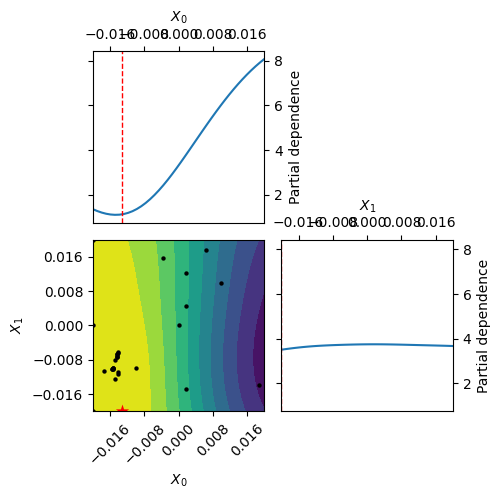

In [10]:
skopt.plots.plot_objective(r)